In [1]:
import os
import pandas as pd
import numpy as np
from scipy.io import mmread
import scipy.sparse as sp
from IPython.display import Image
import scanpy as sc
import yaml
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
P24_Borst_file = '/Users/hoermann/Desktop/Transcriptome_Analysis/RNA-seq_datasets/Hoermann_etal/AnnData/P24_Borst.h5ad'
P24_Borst = sc.read_h5ad(filename=P24_Borst_file)

In [3]:
P24_Borst

AnnData object with n_obs × n_vars = 9920 × 11727

In [4]:
dense_data = pd.DataFrame(P24_Borst.X.todense(), index=P24_Borst.obs.index, columns=P24_Borst.var.index).astype(int)
dense_data.head()

,0,1,2,3,4,5,6,7,8,9,...,11717,11718,11719,11720,11721,11722,11723,11724,11725,11726
0,36,0,0,4,0,0,0,2,2,0,...,0,0,0,0,0,0,0,0,0,0
1,27,0,0,0,0,0,0,5,0,3,...,0,0,0,0,0,0,0,0,0,0
2,43,0,0,4,0,0,0,1,0,3,...,0,0,0,0,0,0,0,0,0,0
3,37,0,0,0,0,0,0,1,0,3,...,0,0,0,0,0,0,0,0,0,0
4,31,0,0,4,0,0,0,0,0,2,...,0,0,0,0,0,0,0,0,0,0


In [5]:
numiter=200 # Number of NMF replicates. Set this to a larger value ~200 for real data. We set this to a relatively low value here for illustration at a faster speed
numworkers=6 # Number of parallel factorization jobs to run. Set this to a value reflective of the number of cores on your computer.
numhvgenes=200 ## Number of over-dispersed genes to use for running the actual factorizations

## Results will be saved to [output_directory]/[run_name] which in this example is example_PBMC/cNMF/pbmc_cNMF
output_directory = '/Users/hoermann/Desktop/Transcriptome_Analysis/cNMF/P24_Borst_cNMF/'
if not os.path.exists(output_directory):
    os.mkdir(output_directory)
run_name = 'P24_Borst_cNMF'

## Specify the Ks to use as a space separated list in this case "5 6 7 8 9 10"
K = ' '.join([str(i) for i in range(5,11)])

## To speed this up, you can run it for only K=7-8 with the option below
#K = ' '.join([str(i) for i in range(7,9)])


seed = 14 ## Specify a seed pseudorandom number generation for reproducibility

In [6]:
## Path to the filtered counts dataset we output previously
count_adat_fn = P24_Borst_file
countfn = '/Users/hoermann/Desktop/Transcriptome_Analysis/RNA-seq_datasets/Hoermann_etal/AnnData/P24_Borst.h5ad'
sc.write(count_adat_fn, P24_Borst)

In [7]:
# Parallel processing

prepare_cmd = 'python /Users/hoermann/Documents/GitHub/cNMF/cnmf.py prepare --output-dir %s --name %s -c %s -k %s --n-iter %d --total-workers %d --seed %d --numgenes %d --beta-loss frobenius' % (output_directory, run_name, countfn, K, numiter, numworkers, seed, numhvgenes)
print('Prepare command assuming parallelization with %d cores:\n%s' % (numworkers, prepare_cmd))
!{prepare_cmd}

Prepare command assuming parallelization with 6 cores:
python /Users/hoermann/Documents/GitHub/cNMF/cnmf.py prepare --output-dir /Users/hoermann/Desktop/Transcriptome_Analysis/cNMF/P24_Borst_cNMF/ --name P24_Borst_cNMF -c /Users/hoermann/Desktop/Transcriptome_Analysis/RNA-seq_datasets/Hoermann_etal/AnnData/P24_Borst.h5ad -k 5 6 7 8 9 10 --n-iter 200 --total-workers 6 --seed 14 --numgenes 200 --beta-loss frobenius
/opt/anaconda3/envs/scanpy/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [ ]:
#Parallel Processing

## Using GNU parallel
## This took 4 minutes in our testing
worker_index = ' '.join([str(x) for x in range(numworkers)])
factorize_cmd = 'nohup parallel python /Users/hoermann/Documents/GitHub/cNMF/cnmf.py factorize --output-dir %s --name %s --worker-index {} ::: %s' % (output_directory, run_name, worker_index)
print('Factorize command to simultaneously run factorization over %d cores using GNU parallel:\n%s' % (numworkers, factorize_cmd))
!{factorize_cmd}

Factorize command to simultaneously run factorization over 6 cores using GNU parallel:
nohup parallel python /Users/hoermann/Documents/GitHub/cNMF/cnmf.py factorize --output-dir /Users/hoermann/Desktop/Transcriptome_Analysis/cNMF/P24_Borst_cNMF/ --name P24_Borst_cNMF --worker-index {} ::: 0 1 2 3 4 5
appending output to nohup.out


In [16]:
# Parallel Processing

cmd = 'python /Users/hoermann/Documents/GitHub/cNMF/cnmf.py combine --output-dir %s --name %s' % (output_directory, run_name)
print(cmd)
!{cmd}

python /Users/hoermann/Documents/GitHub/cNMF/cnmf.py combine --output-dir /Users/hoermann/Desktop/Transcriptome_Analysis/cNMF/P24_Borst_cNMF/ --name P24_Borst_cNMF
Combining factorizations for k=5.
Combining factorizations for k=6.
Combining factorizations for k=7.
Combining factorizations for k=8.
Combining factorizations for k=9.
Combining factorizations for k=10.


In [17]:
kselect_plot_cmd = 'python /Users/hoermann/Documents/GitHub/cNMF/cnmf.py k_selection_plot --output-dir %s --name %s' % (output_directory, run_name)
print('K selection plot command: %s' % kselect_plot_cmd)
!{kselect_plot_cmd}

K selection plot command: python /Users/hoermann/Documents/GitHub/cNMF/cnmf.py k_selection_plot --output-dir /Users/hoermann/Desktop/Transcriptome_Analysis/cNMF/P24_Borst_cNMF/ --name P24_Borst_cNMF


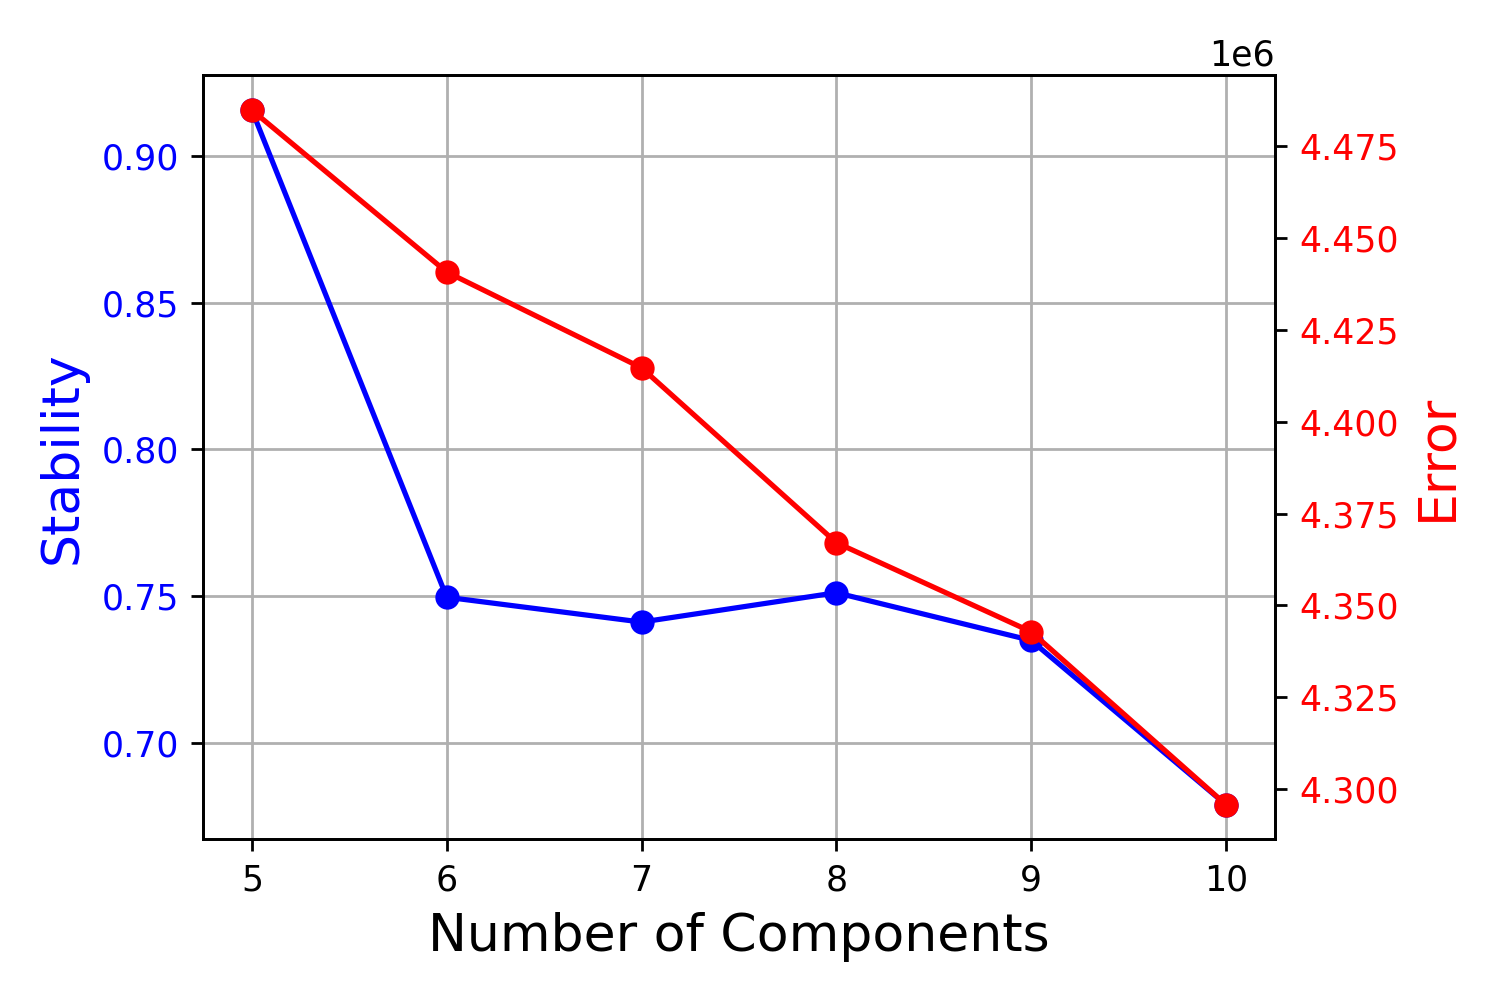

In [19]:
Image(filename = "/Users/hoermann/Desktop/Transcriptome_Analysis/cNMF/P24_Borst_cNMF/P24_Borst_cNMF/P24_Borst_cNMF.k_selection.png",
      width=1000, height=1000)

In [20]:
selected_K = 7
density_threshold = 2.00

In [21]:
## This is the command you would run from the command line to obtain the consensus estimate with no filtering
## and to save a diagnostic plot as a PDF
consensus_cmd = 'python /Users/hoermann/Documents/GitHub/cNMF/cnmf.py consensus --output-dir %s --name %s --local-density-threshold %.2f --components %d --show-clustering' % (output_directory, run_name, density_threshold, selected_K)
print('Consensus command for K=7:\n%s' % consensus_cmd)
!{consensus_cmd}

Consensus command for K=7:
python /Users/hoermann/Documents/GitHub/cNMF/cnmf.py consensus --output-dir /Users/hoermann/Desktop/Transcriptome_Analysis/cNMF/P24_Borst_cNMF/ --name P24_Borst_cNMF --local-density-threshold 2.00 --components 7 --show-clustering
/Users/hoermann/Documents/GitHub/cNMF/cnmf.py:584: RuntimeWarning: invalid value encountered in true_divide
  norm_tpm = (np.array(tpm.X.todense()) - tpm_stats['__mean'].values) / tpm_stats['__std'].values


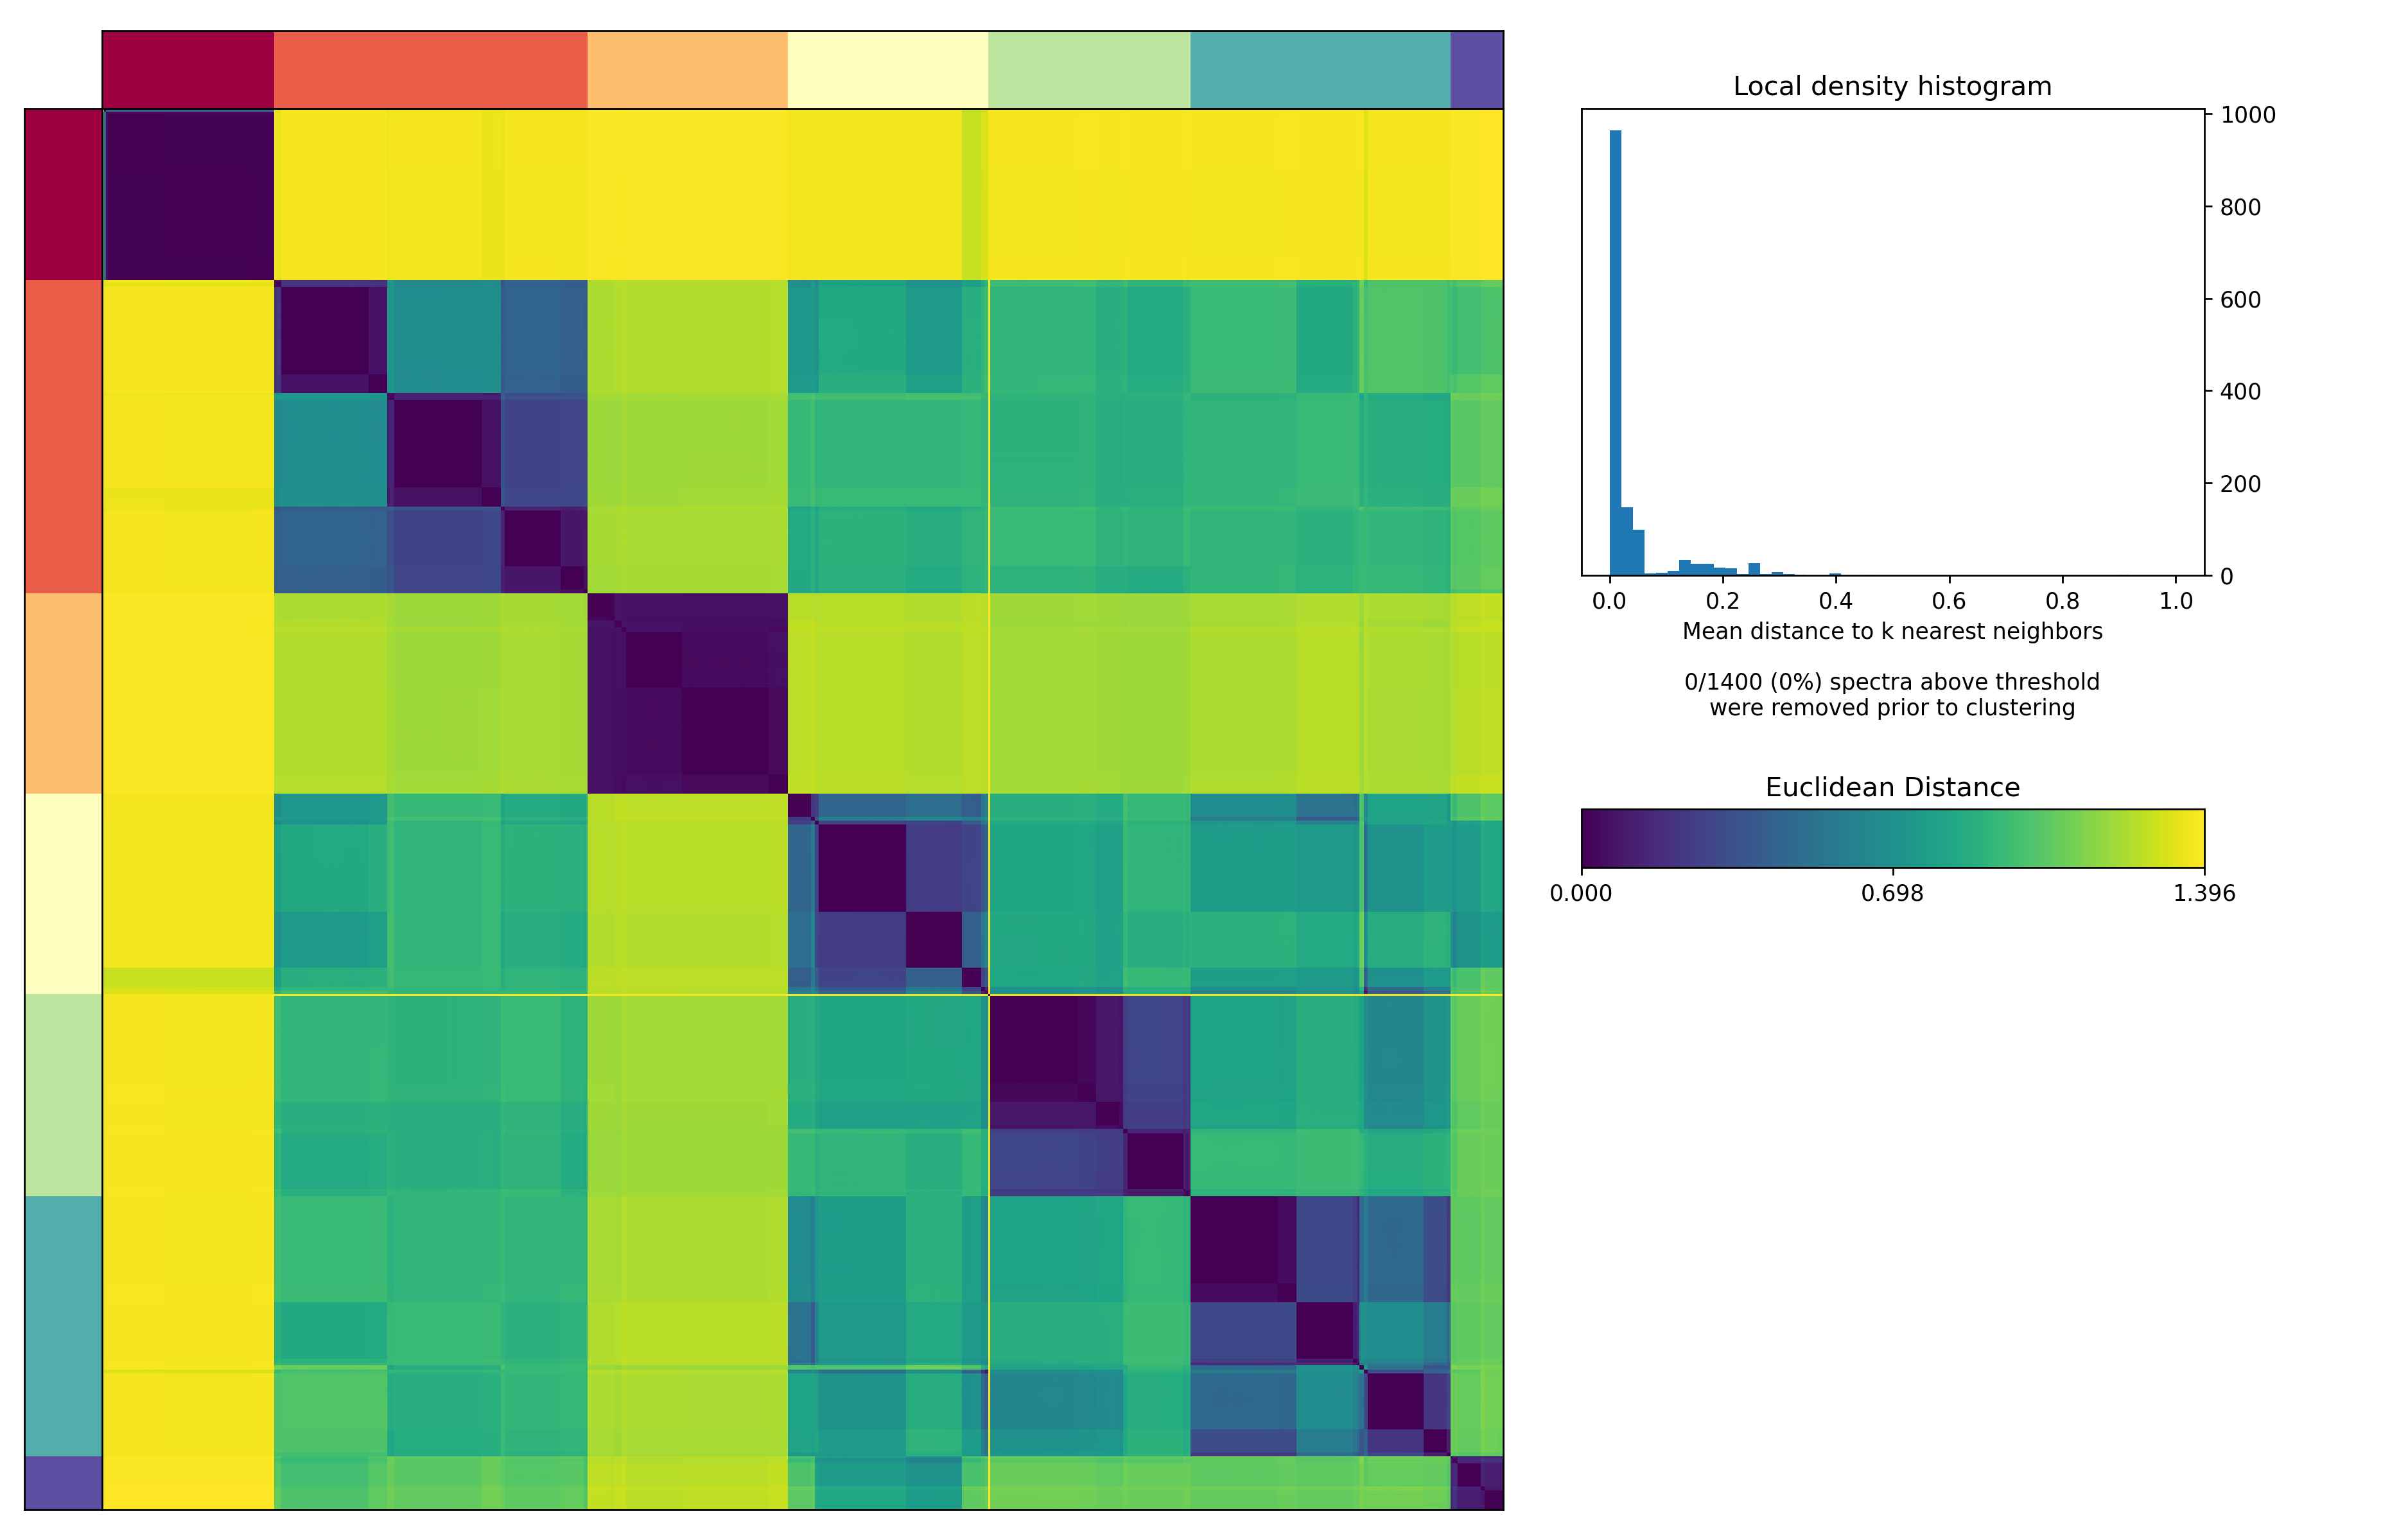

In [22]:
density_threshold_str = ('%.2f' % density_threshold).replace('.', '_')
Image(filename = "/Users/hoermann/Desktop/Transcriptome_Analysis/cNMF/P24_Borst_cNMF/P24_Borst_cNMF/P24_Borst_cNMF.clustering.k_%d.dt_%s.png" % (selected_K, density_threshold_str),
      width=1000, height=1000)

In [23]:
adata = sc.read(countfn)

In [96]:
## Obtain high variance genes that were used for cNMF as these were saved to a text file
hvgs = open('/Users/hoermann/Desktop/Transcriptome_Analysis/cNMF/P24_Borst_cNMF/P24_Borst_cNMF/P24_Borst_cNMF.overdispersed_genes.txt').read().split('\n')

In [25]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=10**4) ## TPT normalization

In [26]:
## Set log-normalized data to the raw attribute of the AnnData object to make it easy to plot expression levels of individual genes.
## This does not log normalize the actual AnnData data matrix
adata.raw = sc.pp.log1p(adata.copy(), copy=True)

In [97]:
## Subset out only the high-variance genes

adata = adata[:,hvgs]

In [28]:
sc.pp.scale(adata)

/opt/anaconda3/envs/scanpy/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [29]:
## Run PCA

sc.pp.pca(adata)

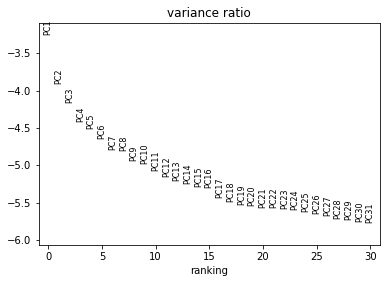

In [30]:
## Make a scree plot to determine number of PCs to use for UMAP

sc.pl.pca_variance_ratio(adata, log=True)

In [31]:
## Construct the nearest neighbor graph for UMAP

sc.pp.neighbors(adata, n_neighbors=20, n_pcs=8)

In [32]:
## Run UMAP

sc.tl.umap(adata)

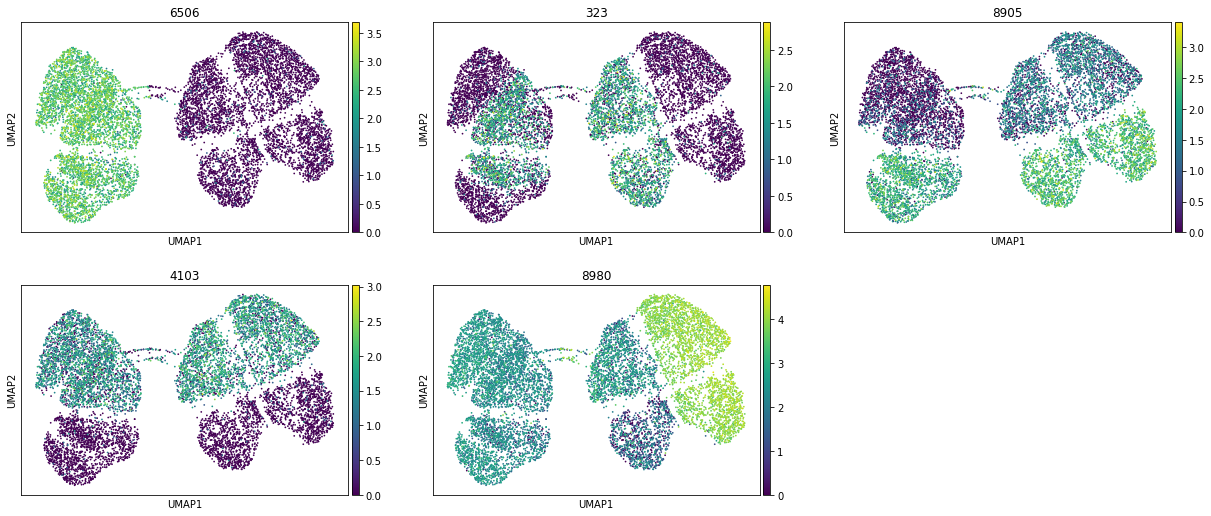

In [115]:
sc.pl.umap(adata, color=['6506', '323', '8905', '4103', '8980'], ncols=3)

In [38]:
## Load the Z-scored GEPs which reflect how enriched a gene is in each GEP relative to all of the others
gene_scores = pd.read_csv('/Users/hoermann/Desktop/Transcriptome_Analysis/cNMF/P24_Borst_cNMF/P24_Borst_cNMF/P24_Borst_cNMF.gene_spectra_score.k_%d.dt_%s.txt' % (selected_K, density_threshold_str),
                    sep='\t', index_col=0).T
gene_scores.head()

,1,2,3,4,5,6,7
0,-0.001490,-0.000161,-0.001944,0.006526,-0.004002,-0.000577,0.006190
1,0.000399,0.000042,-0.002021,0.000713,0.000771,-0.000196,-0.000295
2,-0.000371,-0.000511,-0.001788,0.000388,0.000711,0.000913,-0.000098
3,-0.001019,0.001524,-0.003219,0.002233,-0.003023,0.001287,-0.000754
4,-0.000234,-0.000109,0.000546,-0.000166,0.000232,-0.000135,-0.000280


In [39]:
## Obtain the top 40 genes for each GEP in sorted order and combine them into a single dataframe

top_genes = []
ngenes = 40
for gep in gene_scores.columns:
    top_genes.append(list(gene_scores.sort_values(by=gep, ascending=False).index[:ngenes]))
    
top_genes = pd.DataFrame(top_genes, index=gene_scores.columns).T
top_genes

,1,2,3,4,5,6,7
0,4552,9643,2592,7250,5094,8905,3844
1,6933,6506,1423,7550,2820,3552,3834
2,2100,840,3068,9275,9192,6497,3489
3,6995,1546,3071,2560,8856,5262,8343
4,855,632,758,6287,4628,4077,8734
5,2824,7784,1645,189,5362,1360,282
6,6936,6236,3066,2076,8656,8661,2831
7,8444,6948,2779,2464,7118,9158,6603
8,8646,8509,8535,8485,4057,4660,7975
9,392,9284,677,7167,4707,1909,2859


In [43]:
P24_genes = P24_Borst.var_names

In [81]:
for i in range(39):
    for j in range(6):
        top_genes.iloc[i, j] = P24_genes[int(top_genes.iloc[i, j])]

In [82]:
top_genes

,1,2,3,4,5,6,7
0,Obp44a,mav,Hsp83,mamo,CG17716,kek2,3844
1,CG9686,bi,lncRNA:Hsromega,CG43658,Sf3b6,pHCl-1,3834
2,Obp99a,CG34383,Hsp26,CG42750,CG42389,Fas2,3489
3,CG15209,klg,Hsp23,Tet,dpr2,CG43729,8343
4,Npc2b,pros,Hsp70Bc,futsch,spab,rgn,8734
5,Mdr65,shakB,Hsp68,CG2082,Sema2b,Syp,282
6,Idgf4,sdk,Hsp67Bc,jus,Ggamma30A,Shawl,2831
7,nrv1,CG43902,DnaJ-1,CG7991,Ten-a,CG42817,6603
8,rost,RapGAP1,Sirup,Pvf3,Eip78C,hig,7975
9,CG8369,Fas3,Lk6,fne,Mmp2,Tl,2859


In [93]:
hvgs

['GFP',
 'CG42402',
 'asRNA:CR45999',
 '5-HT2A',
 'CG43427',
 'CG2016',
 'CG2082',
 'side-III',
 'dpr11',
 'lncRNA:CR33938',
 'snRNA:7SK',
 'Nlg3',
 'puc',
 'grn',
 'CG45263',
 'CG8369',
 'pyd',
 'CG8861',
 'ps',
 'MtnA',
 'Glut4EF',
 'hth',
 'CG14687',
 'CG14692',
 'lncRNA:CR43283',
 'pros',
 'dpr5',
 'CG12594',
 'Lk6',
 'l(3)neo38',
 'ClC-a',
 'CG17738',
 'lncRNA:alphagamma-element',
 'Hsp70Bc',
 '2mit',
 'Ace',
 'side-IV',
 'CG34383',
 'Npc2b',
 'Dop1R1',
 'CG3259',
 'NK7.1',
 'cv-c',
 'Pde6',
 'kibra',
 'RpS5b',
 'pxb',
 'CG32855',
 'CG42342',
 'Scp2',
 'modSP',
 'Abd-B',
 'Dscam3',
 'lncRNA:CR45223',
 'sr',
 'fru',
 'CG14301',
 'Octalpha2R',
 'CG5835',
 'Dl',
 'CG31221',
 'CG31220',
 'GluClalpha',
 'Hs6st',
 'CG17193',
 'Oamb',
 'lncRNA:CR44947',
 'Ktl',
 'lncRNA:Hsromega',
 'InR',
 'Eip93F',
 'CG34377',
 'CG13862',
 'CG7069',
 'Octbeta1R',
 'klg',
 'CG17121',
 'CG4467',
 'beat-IV',
 'GILT2',
 'Lsd-1',
 'CG34355',
 'Hsp68',
 'CG6356',
 'nAChRalpha1',
 'slo',
 'AstA',
 'LpR2',
 'Lp

In [92]:
for i in range(len(hvgs)):
    hvgs[i] = P24_genes[int(hvgs[i])]

In [101]:
usage = pd.read_csv('/Users/hoermann/Desktop/Transcriptome_Analysis/cNMF/P24_Borst_cNMF/P24_Borst_cNMF/P24_Borst_cNMF.usages.k_%d.dt_%s.consensus.txt' % (selected_K, density_threshold_str),
                    sep='\t', index_col=0)
usage.columns = ['Usage_%s' % i for i in usage.columns]
usage.head()

,Usage_1,Usage_2,Usage_3,Usage_4,Usage_5,Usage_6,Usage_7
0,1.759078,0.000000,25.309999,0.000000,23.579576,156.593621,73.863442
1,0.000000,0.944341,8.805026,5.691503,155.393504,16.930128,0.000000
2,0.574837,194.937491,34.372797,110.881376,0.000000,0.000000,0.000000
3,7.027656,24.627583,19.059769,21.232254,61.535186,63.498987,55.499302
4,0.000000,0.000000,86.261919,78.948737,32.230424,153.739554,0.000000


In [103]:
usage_norm = usage.div(usage.sum(axis=1), axis=0)
usage_norm.head()

,Usage_1,Usage_2,Usage_3,Usage_4,Usage_5,Usage_6,Usage_7
0,0.006258,0.000000,0.090037,0.000000,0.083882,0.557063,0.262760
1,0.000000,0.005029,0.046894,0.030312,0.827598,0.090167,0.000000
2,0.001687,0.572056,0.100869,0.325388,0.000000,0.000000,0.000000
3,0.027834,0.097542,0.075490,0.084095,0.243722,0.251500,0.219816
4,0.000000,0.000000,0.245634,0.224809,0.091777,0.437779,0.000000


In [104]:
adata.obs = pd.merge(left=adata.obs, right=usage_norm, how='left', left_index=True, right_index=True)

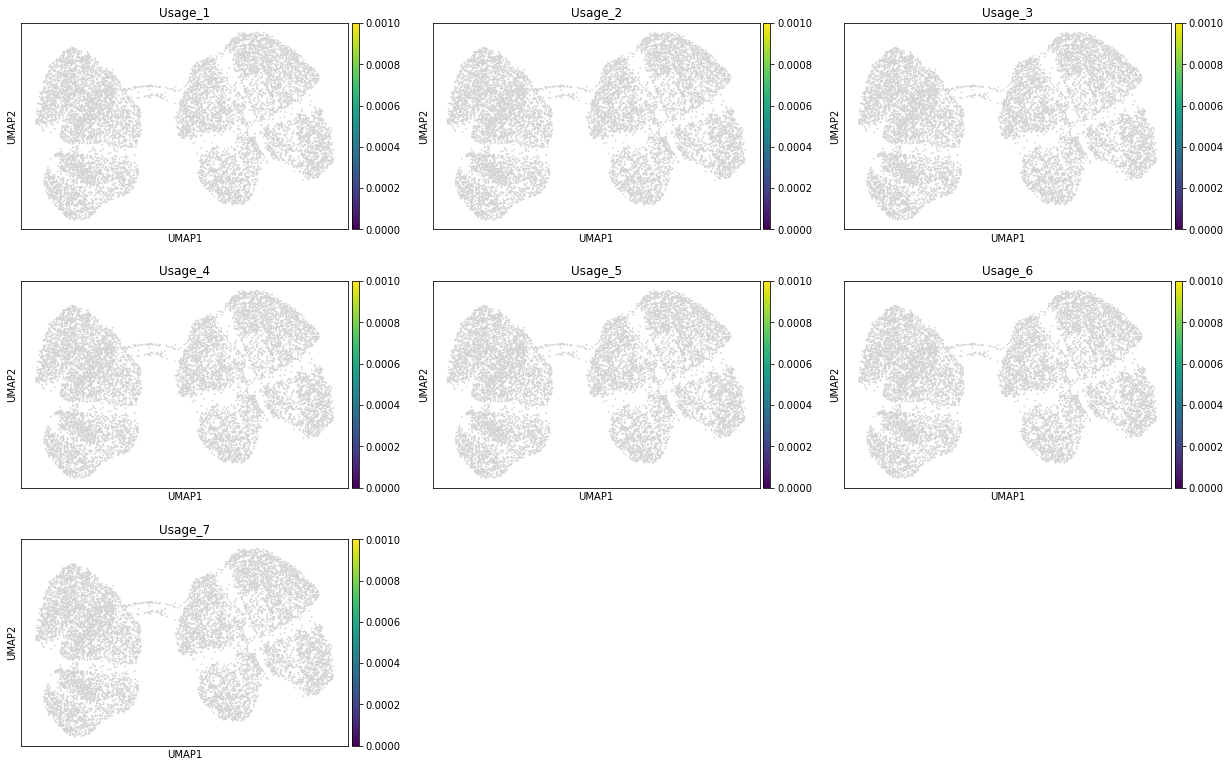

In [108]:
sc.pl.umap(adata, color=usage_norm.columns,
           use_raw=True, ncols=3, vmin=0, vmax=0.001)

In [114]:
P24_genes[8980]

'kek1'

2